In [137]:
import pandas as pd
import matplotlib.pyplot as plt

In [138]:
df = pd.read_csv('../data/titanic_survival/train.csv')

df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [140]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

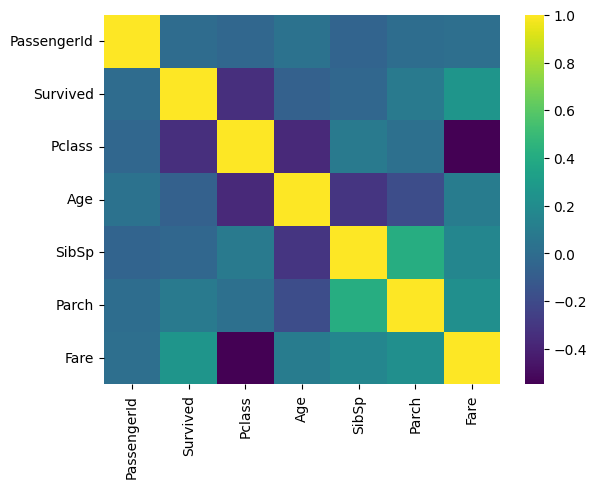

In [141]:
import seaborn as sns

sns.heatmap(df.corr(numeric_only=True), cmap='viridis')

plt.show()


In [142]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_idx, test_idx in split.split(df, df[["Survived", "Pclass", "Sex"]]):
    strat_train_set = df.loc[train_idx].copy()
    strat_test_set = df.loc[test_idx].copy()

<Axes: >

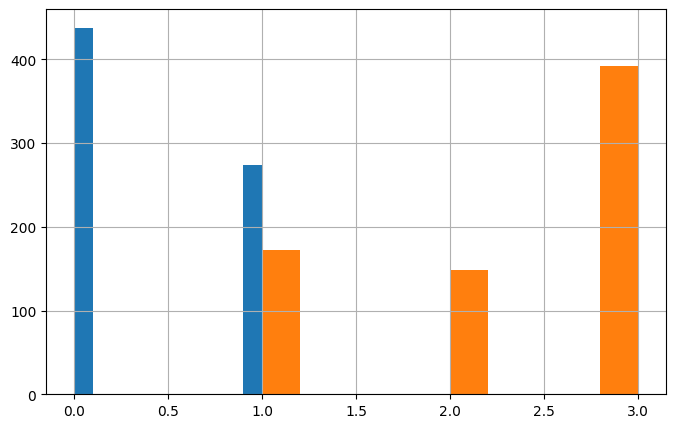

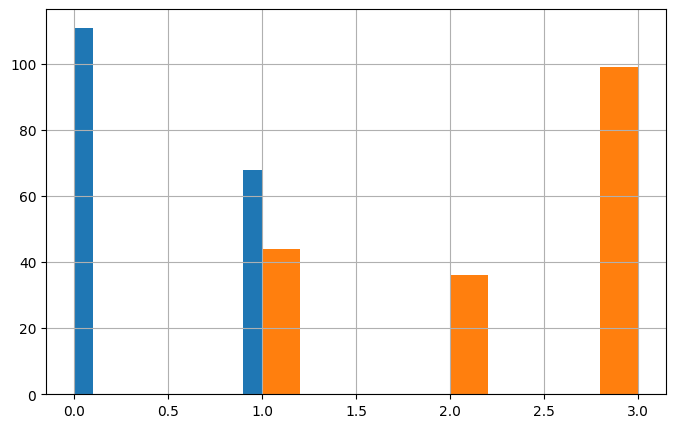

In [143]:
plt.figure(figsize=(8, 5))
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()


plt.figure(figsize=(8, 5))
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

In [144]:
target_col = 'Survived'
cat_cols = ['Sex', 'Embarked']
num_cols = ['Pclass','SibSp','Parch','Fare']

In [145]:
X_train = strat_train_set.drop(target_col, axis=1)
y_train = strat_train_set[target_col]

X_test = strat_test_set.drop(target_col, axis=1)
y_test = strat_test_set[target_col]


X_train['Embarked'] = X_train['Embarked'].fillna('S')

In [146]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_cols),
        ('cat', encoder, cat_cols)
    ],
    remainder='drop'
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


In [147]:
import torch 
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Ensure y is a 2D tensor

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)  # Ensure y is a 2D tensor

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [148]:
import torch.nn as nn   

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)
    

input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim)


In [149]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

optimizer = optim.Adam(model.parameters(),lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.BCEWithLogitsLoss()

## Model Training


In [150]:
epochs = 100

for epoch in range(epochs):
  model.train()
  train_loss_total = 0.0
  
  for inputs, targets in train_loader:
    optimizer.zero_grad()
    y_pred = model(inputs)
    loss = criterion(y_pred,targets)
    loss.backward()
    optimizer.step()
    train_loss_total += loss.item()

  model.eval()
  val_loss_total = 0.0
  correct_predictions = 0
  total_samples = 0
  
  with torch.no_grad():
    for inputs, targets in test_loader:
      y_pred_logits = model(inputs)
      val_loss = criterion(y_pred_logits,targets)
      val_loss_total += val_loss.item()
      y_pred_probs = torch.sigmoid(y_pred_logits)
      
      predicted_classes = (y_pred_probs > 0.5).float()
      correct_predictions += (predicted_classes == targets).sum().item()
      total_samples += targets.size(0)


  avg_train_loss  = train_loss_total/len(train_loader)
  avg_test_loss = val_loss_total / len(test_loader)
  accuracy = correct_predictions / total_samples
  
  if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Test Accuracy: {accuracy:.4f}")

Epoch: 10 | Train Loss: 0.6595 | Test Loss: 0.6479 | Test Accuracy: 0.6536
Epoch: 20 | Train Loss: 0.5893 | Test Loss: 0.5814 | Test Accuracy: 0.7263
Epoch: 30 | Train Loss: 0.5434 | Test Loss: 0.5442 | Test Accuracy: 0.7318
Epoch: 40 | Train Loss: 0.5205 | Test Loss: 0.5200 | Test Accuracy: 0.7486
Epoch: 50 | Train Loss: 0.5033 | Test Loss: 0.5021 | Test Accuracy: 0.7654
Epoch: 60 | Train Loss: 0.4888 | Test Loss: 0.4894 | Test Accuracy: 0.7821
Epoch: 70 | Train Loss: 0.4839 | Test Loss: 0.4802 | Test Accuracy: 0.7877
Epoch: 80 | Train Loss: 0.4657 | Test Loss: 0.4740 | Test Accuracy: 0.7821
Epoch: 90 | Train Loss: 0.4658 | Test Loss: 0.4694 | Test Accuracy: 0.7765
Epoch: 100 | Train Loss: 0.4729 | Test Loss: 0.4663 | Test Accuracy: 0.7709


### Testing with Test Data


In [151]:
test_df = pd.read_csv('../data/titanic_survival/test.csv')

test_df['Embarked'] = test_df['Embarked'].fillna('S')

X_test_processed = preprocessor.transform(test_df)

X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)


In [152]:
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_tensor)
    y_pred_probs = torch.sigmoid(y_pred_logits)
    y_preds = (y_pred_probs > 0.5).int()
    

test_preds_np = y_preds.cpu().numpy().flatten()


test_preds_np[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0], dtype=int32)

### Saving Predictions as Csv File

In [153]:
result = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_preds_np
})


result.to_csv('../data/titanic_survival/titanic_predictions_result.csv', index=False)

result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
